This notebook is a part of the deliverables for my final project for Coding Dojo's Data Science Immersive Bootcamp.
It is in the form of a submission to the [Richter's Predictor: Modeling Earthquake Damage](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/) competition.

In this notebook:
  - [Explore the Nepal 2015 Earthquake data](#eda)
  - [Handle categorical features using one hot encoding and OrdinalEncoding](#handle_cat)
  - [Visualize some feature relationships using seaborn and bokeh](#viz)
  - [Predict damage using Gradient Boosting Classifier](#gbi)
  - [Check feature importances, make another prediction and compare results](#feat_imp)
  - [Apply SMOTE to handle class imbalance, make another prediction and compare results](#SMOTE)
  - [Upload csv submissions files](#submit)
  - [Submit](https://www.drivendata.org/competitions/57/nepal-earthquake/submissions/) predictions to the competition!

In [1]:
# import packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder #?
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
sns.set_style("darkgrid")
import imblearn

In [2]:
# data files from: https://www.drivendata.org/competitions/57/nepal-earthquake/data/
train_values = pd.read_csv('https://raw.githubusercontent.com/AtheerMalki/Module04_ML/main/Project/data/train_values.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/AtheerMalki/Module04_ML/main/Project/data/train_labels.csv')

test_values = pd.read_csv('https://raw.githubusercontent.com/AtheerMalki/Module04_ML/main/Project/data/test_values.csv')

<a name="eda"></a>
# EDA


Observe shape of each dataframe

In [3]:
print('train values shape:', train_values.shape)
print('train labels shape:', train_labels.shape)
print('test values shape:', test_values.shape)

train values shape: (260601, 39)
train labels shape: (260601, 2)
test values shape: (86868, 39)


Merge training and testing values

In [4]:
# 1st: copy [train_labels]'s 'damage_grade' column to [train_values]
train_values['damage_grade'] = train_labels['damage_grade'].values

# 2nd: concatenate train_values and test_values
frames = [train_values, test_values]
df = pd.concat(frames)
df.set_index='building_id'
df.shape

(347469, 40)

In [5]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3.0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2.0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3.0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2.0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3.0


***Features Description*** 

- **geo_level_1_id, geo_level_2_id, geo_level_3_id (type: int):** geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.  

- **count_floors_pre_eq (type: int):** number of floors in the building before the earthquake.  

- **age (type: int):** age of the building in years.  

- **area_percentage (type: int):** normalized area of the building footprint.  

- **height_percentage (type: int):** normalized height of the building footprint.  

- **land_surface_condition (type: categorical):** surface condition of the land where the building was built. Possible values: n, o, t.  

- **foundation_type (type: categorical):** type of foundation used while building. Possible values: h, i, r, u, w.  

- **roof_type (type: categorical):** type of roof used while building. Possible values: n, q, x.  

- **ground_floor_type (type: categorical):** type of the ground floor. Possible values: f, m, v, x, z.  

- **other_floor_type (type: categorical):** type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.   

- **position (type: categorical):** position of the building. Possible values: j, o, s, t.  

- **plan_configuration (type: categorical):** building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.   

- **has_superstructure_adobe_mud (type: binary):** flag variable that indicates if the superstructure was made of Adobe/Mud.  

- **has_superstructure_mud_mortar_stone (type: binary):** flag variable that indicates if the superstructure was made of Mud Mortar - Stone.  

- **has_superstructure_stone_flag (type: binary):** flag variable that indicates if the superstructure was made of Stone.  

- **has_superstructure_cement_mortar_stone (type: binary):** flag variable that indicates if the superstructure was made of Cement Mortar - Stone.

- **has_superstructure_mud_mortar_brick (type: binary):** flag variable that indicates if the superstructure was made of Mud Mortar - Brick.  

- **has_superstructure_cement_mortar_brick (type: binary):** flag variable that indicates if the superstructure was made of Cement Mortar - Brick.  

- **has_superstructure_timber (type: binary):** flag variable that indicates if the superstructure was made of Timber.  

- **has_superstructure_bamboo (type: binary):** flag variable that indicates if the superstructure was made of Bamboo.  

- **has_superstructure_rc_non_engineered (type: binary):** flag variable that indicates if the superstructure was made of non-engineered reinforced concrete.  

- **has_superstructure_rc_engineered (type: binary):** flag variable that indicates if the superstructure was made of engineered reinforced concrete.  

- **has_superstructure_other (type: binary):** flag variable that indicates if the superstructure was made of any other material.  

- **legal_ownership_status (type: categorical):** legal ownership status of the land where building was built. Possible values: a, r, v, w.  

- **count_families (type: int):** number of families that live in the building.  

- **has_secondary_use (type: binary):** flag variable that indicates if the building was used for any secondary purpose.  

- **has_secondary_use_agriculture (type: binary):** flag variable that indicates if the building was used for agricultural purposes.  

- **has_secondary_use_hotel (type: binary):** flag variable that indicates if the building was used as a hotel.  

- **has_secondary_use_rental (type: binary):** flag variable that indicates if the building was used for rental purposes.  

- **has_secondary_use_institution (type: binary):** flag variable that indicates if the building was used as a location of any institution.  

- **has_secondary_use_school (type: binary):** flag variable that indicates if the building was used as a school.  

- **has_secondary_use_industry (type: binary):** flag variable that indicates if the building was used for industrial purposes.  

- **has_secondary_use_health_post (type: binary):** flag variable that indicates if the building was used as a health post.  

- **has_secondary_use_gov_office (type: binary):** flag variable that indicates if the building was used fas a government office.  

- **has_secondary_use_use_police (type: binary):** flag variable that indicates if the building was used as a police station.  

- **has_secondary_use_other (type: binary):** flag variable that indicates if the building was secondarily used for other purposes.
- **damage_grade (type: int):** represents the level of damage. 1: low damage. 2: medium damage. 3: great damage/destruction.

In [6]:
# check for missing values
# function to check missing values per column
def missing_values_table(df):
    # total missing values
    mis_val = df.isnull().sum()
    
    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # print some summary information
    print("Your selected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
missing_values_table(df)

Your selected dataframe has 40 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
damage_grade,86868,25.0


Theses 86868 values are in fact the *to be predected labels* = there are no missing values, nice!

<a name="handle_cat"></a>
## Handle categorical features

In [8]:
# observe columns and their types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347469 entries, 0 to 86867
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             347469 non-null  int64  
 1   geo_level_1_id                          347469 non-null  int64  
 2   geo_level_2_id                          347469 non-null  int64  
 3   geo_level_3_id                          347469 non-null  int64  
 4   count_floors_pre_eq                     347469 non-null  int64  
 5   age                                     347469 non-null  int64  
 6   area_percentage                         347469 non-null  int64  
 7   height_percentage                       347469 non-null  int64  
 8   land_surface_condition                  347469 non-null  object 
 9   foundation_type                         347469 non-null  object 
 10  roof_type                               34746

This dataframe has 31 columns of type **int64**, 8 columns of type **object**, and a single **float46** column(the target). 

In [9]:
# we want to change all columns to be of numerical type

# first, let's investigate the columns with type 'object'
print(train_values['land_surface_condition'].value_counts(), '\n')
print(train_values['foundation_type'].value_counts(), '\n')
print(train_values['roof_type'].value_counts(), '\n')
print(train_values['ground_floor_type'].value_counts(), '\n')

print(train_values['other_floor_type'].value_counts(), '\n')
print(train_values['position'].value_counts(), '\n')
print(train_values['plan_configuration'].value_counts(), '\n')
print(train_values['legal_ownership_status'].value_counts(), '\n')

print(train_values['damage_grade'].value_counts(), '\n')

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64 

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64 

n    182842
q     61576
x     16183
Name: roof_type, dtype: int64 

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64 

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64 

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64 

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64 

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64 

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64 



We will deal with each column depending on the number of classes it has

In [10]:
# use OrdinalEncoder to deal with object columns with 4 or more classes
four_more = ['foundation_type', 'ground_floor_type', 'plan_configuration',
             'other_floor_type', 'position', 'legal_ownership_status']
enc = OrdinalEncoder()

df[four_more] = enc.fit_transform(df[four_more])

In [11]:
# use one hot encoding to deal with object columns with 3 or less classes
three_less = ['land_surface_condition', 'roof_type']
df = pd.get_dummies(df, columns=three_less)

In [12]:
# check everything is good and all columns are numerical
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347469 entries, 0 to 86867
Data columns (total 44 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             347469 non-null  int64  
 1   geo_level_1_id                          347469 non-null  int64  
 2   geo_level_2_id                          347469 non-null  int64  
 3   geo_level_3_id                          347469 non-null  int64  
 4   count_floors_pre_eq                     347469 non-null  int64  
 5   age                                     347469 non-null  int64  
 6   area_percentage                         347469 non-null  int64  
 7   height_percentage                       347469 non-null  int64  
 8   foundation_type                         347469 non-null  float64
 9   ground_floor_type                       347469 non-null  float64
 10  other_floor_type                        34746

In [13]:
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type,ground_floor_type,...,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,roof_type_n,roof_type_q,roof_type_x
count,3.474690e+05,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,...,347469.000000,347469.000000,347469.000000,260601.000000,347469.000000,347469.000,347469.000000,347469.000000,347469.000000,347469.000000
mean,5.259136e+05,13.897315,701.838052,6258.846760,2.130579,26.538814,8.017014,5.434799,2.117731,0.491638,...,0.000138,0.000078,0.005065,2.238272,0.136452,0.032,0.831548,0.702149,0.235719,0.062132
std,3.043545e+05,8.032597,412.875674,3646.950564,0.727761,73.527749,4.388646,1.915555,0.578523,1.027676,...,0.011753,0.008815,0.070990,0.611814,0.343269,0.176,0.374268,0.457314,0.424448,0.241396
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
25%,2.619990e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000,1.000000,0.000000,0.000000,0.000000
50%,5.260710e+05,12.000000,706.000000,6271.000000,2.000000,15.000000,7.000000,5.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000,1.000000,1.000000,0.000000,0.000000
75%,7.895880e+05,21.000000,1050.000000,9414.000000,2.000000,30.000000,9.000000,6.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000,1.000000,1.000000,0.000000,0.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,4.000000,4.000000,...,1.000000,1.000000,1.000000,3.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000


<a name="viz"></a>
## Visualization

In [14]:
#import pandas_profiling
#pandas_profiling.ProfileReport(train_values)

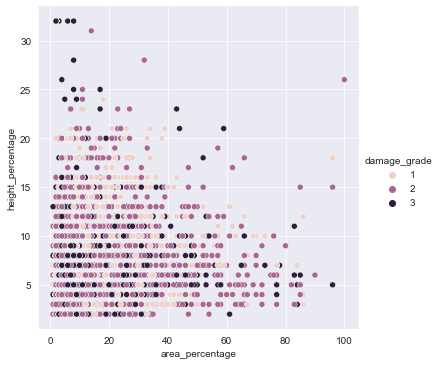

In [50]:
# plot the relation between a building's area and height with distinction of the damage grade
sns.relplot(
    data=train_values,
    x="area_percentage", y="height_percentage",
    hue="damage_grade", aspect=11.7/9
)

There are many purple points!  
Top-Left: several buildings with high percentage of height and relatively smaller areas appear to be classified with damage_grade **3**. It seems fair to assume the higher the building, and the smaller its area, the more damage it will endure.

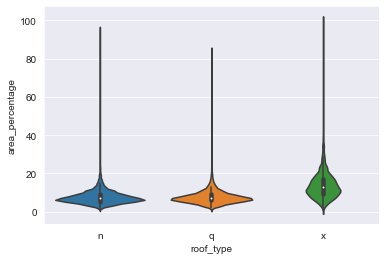

In [16]:
# the area percentage for buildings white taking note of the roof type
sns.violinplot(x='roof_type', y='area_percentage', data=train_values)

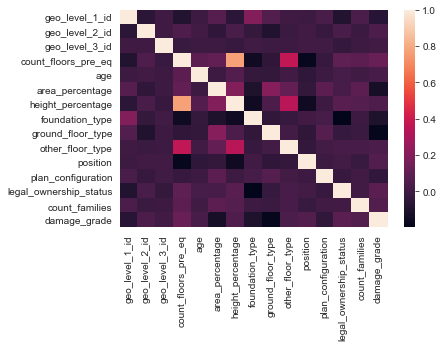

In [17]:
# plot the heatmap to plot correlation between features
without_flags = [
 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'foundation_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status',
 'count_families',
 'damage_grade',]
corr = df[without_flags].corr()
sns.heatmap(corr)

There seems to be some correlation between the features *geo_level_1_id* and *foundation_type*, intersting. Also between *area_percentage* and *ground_floor_type*.   
Some obvious correlations can be seen such as the one between the building's height and the count of floors.

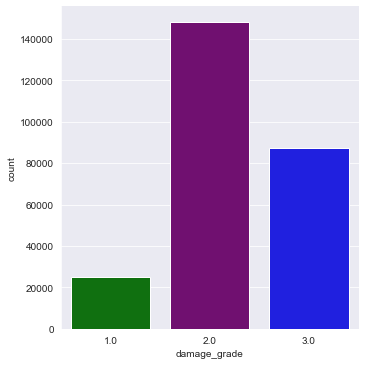

In [18]:
# A barplot showing how many instances of each class there are
sns.catplot(x='damage_grade', data=df, kind='count', palette=sns.color_palette(['green','purple', 'blue']))

<a name="imbalance"></a>
According to this plot, there seems to be a multiclass imbalance. This means that in this dataset there are more instances where the damage_grade is 2, but less ones where the damage_grade is 1 or 3. This is a problem because the model is not going to be trained well to predict the classes where there is less data. 
One way to fix this is using SMOTE.  

With SMOTE (Synthetic Minority Over-sampling Technique), we can either oversample or undersample certain classes.  


We will get to performing SMOTE [later](#SMOTE) in the notebook.

In [19]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type,ground_floor_type,...,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,roof_type_n,roof_type_q,roof_type_x
0,802906,6,487,12198,2,30,6,5,2.0,0.0,...,0,0,0,3.0,0,0,1,1,0,0
1,28830,8,900,2812,2,10,8,7,2.0,3.0,...,0,0,0,2.0,0,1,0,1,0,0
2,94947,21,363,8973,2,10,5,5,2.0,0.0,...,0,0,0,3.0,0,0,1,1,0,0
3,590882,22,418,10694,2,10,6,5,2.0,0.0,...,0,0,0,2.0,0,0,1,1,0,0
4,201944,11,131,1488,3,30,8,9,2.0,0.0,...,0,0,0,3.0,0,0,1,1,0,0


# Predict Damage

First, let's the prepare data

In [20]:
# seperate training and testing data 
new_train_values = df.iloc[:260601,]
new_test_values = df.iloc[260601:,]

new_test_values = new_test_values.drop('damage_grade', axis=1)

print('train values shape:', new_train_values.shape)
print('test values shape:', new_test_values.shape)

train values shape: (260601, 44)
test values shape: (86868, 43)


<a name="gbi"></a>
## Gradient Boosting Classifier

In [21]:
x=new_train_values.drop('damage_grade', axis=1)
y=new_train_values['damage_grade']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=43)

print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

X_train : (182420, 43)
X_test : (78181, 43)
y_train : (182420,)
y_test : (78181,)


- learning_rate : shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

- max_depth :  limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

- n_estimators : The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

- min_samples_split : The minimum number of samples required to split an internal node.

- max_features : The number of features to consider when looking for the best split

- verbose:  If 1 then it prints progress and performance once in a while (the more trees the lower the frequency).

In [22]:
GBI = GradientBoostingClassifier(
                                learning_rate=0.01, 
                                max_depth=4,
                                n_estimators = 500,
                                max_features= "sqrt",
                                #random_state=42,
                                verbose = 1
                                )

In [23]:
GBI.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1      166311.5016           20.92m
         2      166062.2040           21.45m
         3      165768.8950           21.78m
         4      165420.8893           21.78m
         5      165078.7463           22.06m
         6      164781.1136           21.80m
         7      164606.4587           21.76m
         8      164354.3965           21.92m
         9      164093.4797           21.79m
        10      163801.2604           21.94m
        20      161396.4391           21.50m
        30      159207.9025           20.89m
        40      157325.5873           20.76m
        50      155656.6486           20.38m
        60      154182.1866           20.02m
        70      152929.0644           19.31m
        80      151703.0482           18.63m
        90      150587.2702           18.06m
       100      149674.2475           17.46m
       200      142572.2525           12.69m
       300      138742.5295            8.65m
       40

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='sqrt',
                           n_estimators=500, verbose=1)

In [24]:
predictions = GBI.predict(X_test)

In [25]:
def prediction_result(matrix):

    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    print("Accuracy: __ %1.3f" % ((TP+TN)/(TP+FP+FN+TN)))
    print("Sensitivity: %1.3f" % (TP/(TP+FN)))
    print("Specificity: %1.3f" % (TN/(FP+TN)))
    print("F1-Score: __ %1.3f" % ((2*TP)/(2*TP+FP+FN)))
    print("Confusion matrix:\n", matrix)

In [26]:
prediction_result(confusion_matrix(y_test, predictions))

Accuracy: __ 0.872
Sensitivity: 0.644
Specificity: 0.891
F1-Score: __ 0.442
Confusion matrix:
 [[ 2512  4947    44]
 [ 1388 40470  2645]
 [   83 17541  8551]]


## Feature Importances

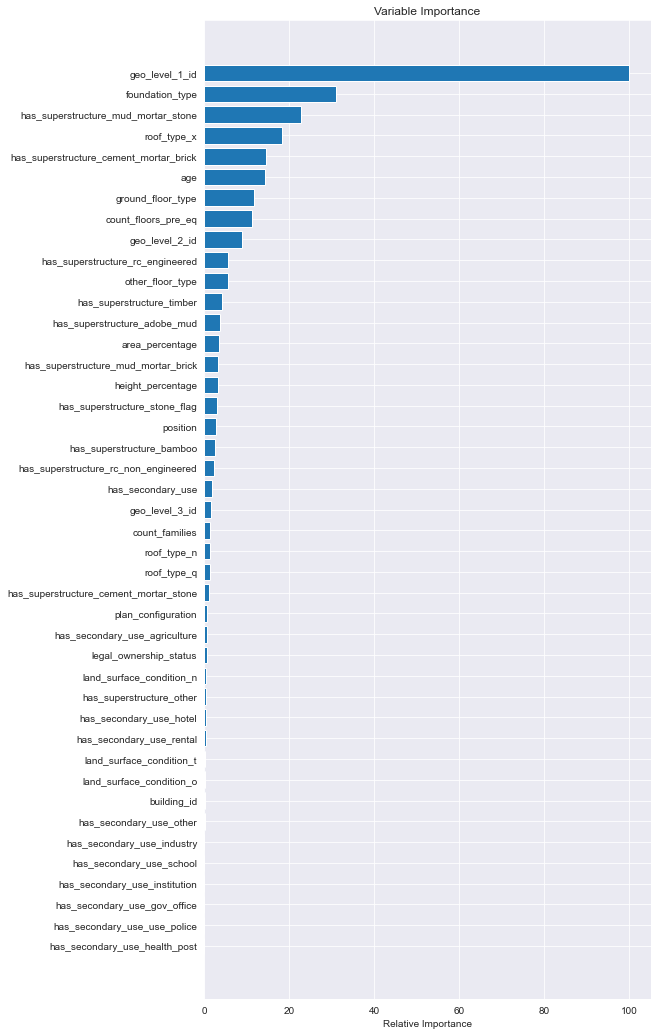

In [27]:
# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = GBI.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [28]:
# select top 26 features (arbitrary choice from looking at the graph above)
#list(df)
top_features = ['geo_level_1_id', 'foundation_type', 'has_superstructure_mud_mortar_stone', 'roof_type_x',
                'has_superstructure_cement_mortar_brick', 'age', 'count_floors_pre_eq', 'ground_floor_type',
                'geo_level_2_id', 'other_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_rc_engineered',
                'has_superstructure_timber', 'has_superstructure_mud_mortar_brick', 'area_percentage',
                'has_superstructure_stone_flag', 'position', 'height_percentage', 'has_superstructure_bamboo',
                'has_superstructure_rc_non_engineered', 'geo_level_3_id', 'has_secondary_use', 'roof_type_q',
                'roof_type_n', 'count_families', 'has_superstructure_cement_mortar_stone']

In [29]:
X_fs = new_train_values[top_features]
y_fs = new_train_values['damage_grade']

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs, y_fs, test_size=0.30, random_state=43)

print('X_train :', X_train_fs.shape)
print('X_test :', X_test_fs.shape)
print('y_train :', y_train_fs.shape)
print('y_test :', y_test_fs.shape)

X_train : (182420, 26)
X_test : (78181, 26)
y_train : (182420,)
y_test : (78181,)


In [30]:
GBI_fs = GradientBoostingClassifier(
                                learning_rate=0.01, 
                                max_depth=4,
                                n_estimators = 500,
                                max_features= "sqrt",
                                #random_state=42,
                                verbose = 1
                                )

In [31]:
GBI_fs.fit(X_train_fs, y_train_fs)

      Iter       Train Loss   Remaining Time 
         1      166241.1281           23.13m
         2      165930.8879           23.12m
         3      165581.7545           22.33m
         4      165231.7587           22.17m
         5      164888.4777           21.80m
         6      164556.7482           21.71m
         7      164257.4266           21.71m
         8      163951.7063           21.42m
         9      163635.5117           21.43m
        10      163370.0036           21.20m
        20      160533.3704           20.86m
        30      158323.8461           20.29m
        40      156143.0824           19.89m
        50      154284.7943           19.40m
        60      152873.6371           19.04m
        70      151529.5033           18.56m
        80      150380.6419           18.02m
        90      149088.4615           17.47m
       100      148007.3576           16.91m
       200      140584.2506           12.86m
       300      136516.7903            9.00m
       40

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='sqrt',
                           n_estimators=500, verbose=1)

In [32]:
predictions_fs = GBI_fs.predict(X_test_fs)

In [33]:
prediction_result(confusion_matrix(y_test_fs, predictions_fs))

Accuracy: __ 0.872
Sensitivity: 0.646
Specificity: 0.892
F1-Score: __ 0.448
Confusion matrix:
 [[ 2555  4901    47]
 [ 1399 40374  2730]
 [   80 17286  8809]]


<a name="SMOTE"></a>
## Perform SMOTE

As mentioned [earlier](#imbalance), the data suffers from imbalance. We will deal with it using SMOTE.

In [34]:
classes = df['damage_grade'].value_counts()
tot = len(df['damage_grade'])
for cl in classes:
  print(cl, '->', round(cl/tot*100, 2), '%')

148259 -> 42.67 %
87218 -> 25.1 %
25124 -> 7.23 %


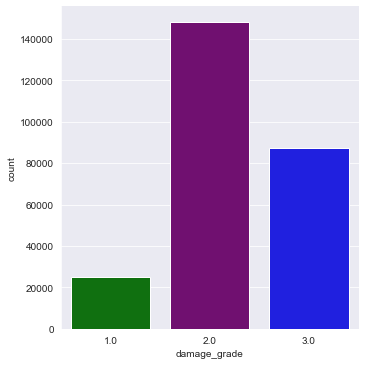

In [51]:
sns.catplot(x='damage_grade', data=df, kind='count', palette=sns.color_palette(['green','purple', 'blue']))

In [36]:
X_fs_sm = X_fs
y_fs_sm = y_fs

X_train_fs_sm, X_test_fs_sm, y_train_fs_sm, y_test_fs_sm = train_test_split(X_fs_sm, y_fs_sm, test_size=0.30, random_state=43)

print('X_train :', X_train_fs_sm.shape)
print('X_test :', X_test_fs_sm.shape)
print('y_train :', y_train_fs_sm.shape)
print('y_test :', y_test_fs_sm.shape)

X_train : (182420, 26)
X_test : (78181, 26)
y_train : (182420,)
y_test : (78181,)


In [37]:
sm = SMOTE(random_state = 2)

In [38]:
X_smoted, y_smoted = sm.fit_sample(X_train_fs_sm, y_train_fs_sm)

In [39]:
GBI_fs_sm = GradientBoostingClassifier(
                                learning_rate=0.01, 
                                max_depth=4,
                                n_estimators = 500,
                                max_features= "sqrt",
                                #random_state=42,
                                verbose = 1
                                )

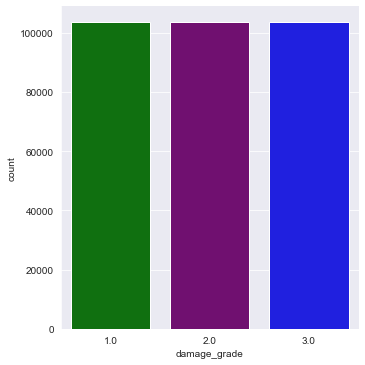

In [53]:
# After SMOTE
temp_df = X_smoted
temp_df['damage_grade'] = y_smoted
sns.catplot(x='damage_grade', data=X_smoted, kind='count', palette=sns.color_palette(['green','purple', 'blue']))

In [40]:
GBI_fs_sm.fit(X_smoted, y_smoted)

      Iter       Train Loss   Remaining Time 
         1      340673.4056           37.26m
         2      339453.0975           38.08m
         3      338121.4028           39.14m
         4      336773.0037           40.23m
         5      335425.3413           39.79m
         6      334176.0034           39.86m
         7      332909.7286           40.07m
         8      331609.0023           39.98m
         9      330381.6176           40.04m
        10      329277.8457           40.19m
        20      318686.1643           39.38m
        30      309762.6125           40.91m
        40      301578.6443           42.20m
        50      294748.5880           41.92m
        60      288319.9727           41.18m
        70      282693.0905           40.37m
        80      277821.4899           39.60m
        90      273114.5506           38.75m
       100      268959.9134           37.88m
       200      242367.7056           28.08m
       300      228406.0112           18.53m
       40

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='sqrt',
                           n_estimators=500, verbose=1)

In [45]:
predictions_fs_sm = GBI_fs_sm.predict(X_test_fs_sm)

In [46]:
prediction_result(confusion_matrix(y_test_fs_sm, predictions_fs_sm))

Accuracy: __ 0.810
Sensitivity: 0.475
Specificity: 0.922
F1-Score: __ 0.556
Confusion matrix:
 [[ 4604  2276   623]
 [ 5086 26839 12578]
 [  595  9052 16528]]


<a name="submit"></a>
Predict and upload csv files of respective method

In [47]:
# Gradient Boosting Classifier | NO Feature Selection & NO SMOTE
predictions = GBI.predict(new_test_values)

result = pd.DataFrame({'building_id': new_test_values.building_id, 'damage_grade': predictions.astype(int)})
result.to_csv('GBI_earthquake_damage_attempt_1.csv', index=False)

In [48]:
# Gradient Boosting Classifier | YES Feature Selection & NO SMOTE
predictions_fs = GBI_fs.predict(new_test_values[top_features])

result = pd.DataFrame({'building_id': new_test_values.building_id, 'damage_grade': predictions_fs.astype(int)})
result.to_csv('GBI_fs_earthquake_damage_attempt_1.csv', index=False)

In [49]:
# Gradient Boosting Classifier | YES Feature Selection & YES SMOTE
predictions_fs_sm = GBI_fs_sm.predict(new_test_values[top_features])

result = pd.DataFrame({'building_id': new_test_values.building_id, 'damage_grade': predictions_fs_sm.astype(int)})
result.to_csv('GBI_fs_sm_earthquake_damage_attempt_1.csv', index=False)